In [79]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import torch

In [80]:
# Définition des constantes
a = 1.0  # Période du réseau
r = 0.3 * a  # Rayon des trous
epsilon_r = 12.0  # Permittivité relative du matériau
nx, ny = 1, 1  # Nombre de périodes en x et y

In [81]:
# Définition de la géométrie
def create_geometry(nx, ny, a, r, w1=True):
    # Créer un rectangle pour la cellule unitaire
    geom = dde.geometry.Rectangle([-a/2, -a*np.sqrt(3)/4], [(a/2), (a*np.sqrt(3)/4)])
    

    holes_pos = []
    holes = []
    for ix in range(nx):
        for iy in range(ny):
            x = ix * a
            y = iy * a * np.sqrt(3) / 2
            
            # Décalage pour les colonnes paires
            if ix % 2 == 1:
                y += a * np.sqrt(3) / 4
            
            # Ajouter le trou, sauf si on crée un guide W1 et qu'on est sur la ligne centrale
            if not (w1 and iy == ny // 2):
                hole = dde.geometry.Disk([x, y], r)
                holes.append(hole)
                holes_pos.append((x, y))
    
    # Soustraire tous les trous de la géométrie
    for hole in holes:
        geom = dde.geometry.CSGDifference(geom, hole)
    
    return geom, holes_pos


# Définition de l'équation d'onde pour les modes TE
def pde(x, y):
    # Équation d'onde simplifiée pour les modes TE
    del2_y = dde.grad.hessian(y, x, i=0, j=0) + dde.grad.hessian(y, x, i=1, j=1)
    return del2_y + epsilon_r * y

"""
# Conditions aux limites périodiques
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], -a/2)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], a/2)

def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], -a*np.sqrt(3)/4)

def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], a*np.sqrt(3)/4)
"""

# Conditions aux limites périodiques
def boundary_left(x, on_boundary):
    return on_boundary #and np.isclose(x[0], -a/2)

def boundary_right(x, on_boundary):
    return on_boundary #and np.isclose(x[0], (a/2) * nx)  # Ajusté pour englober toutes les mailles

def boundary_bottom(x, on_boundary):
    return on_boundary #and np.isclose(x[1], -a * np.sqrt(3)/4)

def boundary_top(x, on_boundary):
    return on_boundary #and np.isclose(x[1], (a * np.sqrt(3)/4) * ny*2)  # Ajusté pour englober toutes les mailles


def create_photonic_crystal_structure(nx, ny, a, r, w1=True):
    """
    Crée la structure d'un cristal photonique avec un guide d'onde W1 optionnel.
    
    :param nx: Nombre de périodes en x
    :param ny: Nombre de périodes en y
    :param a: Période du réseau
    :param r: Rayon des trous
    :param w1: Si True, crée un guide d'onde W1
    :return: Liste de coordonnées (x, y) des trous
    """
    holes = []
    for ix in range(nx):
        for iy in range(ny):
            x = ix * a
            y = iy * a * np.sqrt(3) / 2
            
            # Décalage pour les colonnes paires
            if ix % 2 == 1:
                y += a * np.sqrt(3) / 4
            
            # Ajouter le trou, sauf si on crée un guide W1 et qu'on est sur la ligne centrale
            if not (w1 and iy == ny // 2):
                holes.append((x, y))
    
    return holes

In [82]:
geom, holes = create_geometry(nx, ny, a, r, w1=False)
bc_left = dde.DirichletBC(geom, lambda x: 0, boundary_left)
bc_right = dde.DirichletBC(geom, lambda x: 0, boundary_right)
bc_bottom = dde.DirichletBC(geom, lambda x: 0, boundary_bottom)
bc_top = dde.DirichletBC(geom, lambda x: 0, boundary_top)


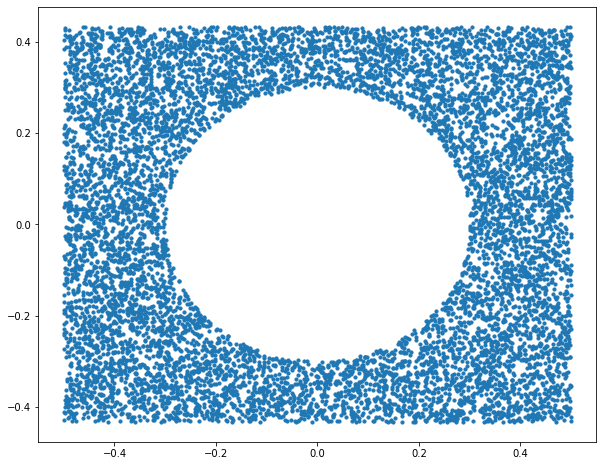

In [83]:
#generate a geometry
x_geom = geom.random_points(10000)
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x_geom[:, 0], x_geom[:, 1], s=10)

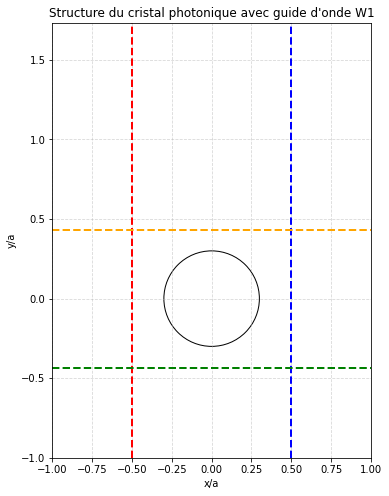

In [92]:

# Créer la figure
fig, ax = plt.subplots(figsize=(10, 8))

# Dessiner les trous
for x, y in holes:
    circle = Circle((x, y), r, fill=False, color='black')
    ax.add_artist(circle)

# Configurer les axes
ax.set_xlim(-1, (nx)*a)
ax.set_ylim(-1, (ny+1)*a*np.sqrt(3)/2)
ax.set_aspect('equal', 'box')

# Ajouter des titres et des labels
ax.set_title("Structure du cristal photonique avec guide d'onde W1")
ax.set_xlabel("x/a")
ax.set_ylabel("y/a")

# Afficher la grille
ax.grid(True, linestyle='--', alpha=0.5)


# Tracer les conditions aux limites
# Tracer les conditions aux limites
plt.axvline(x=-a/2, color='red', linestyle='--', linewidth=2, label='Limite gauche')
plt.axvline(x=(a/2) * nx, color='blue', linestyle='--', linewidth=2, label='Limite droite')
plt.axhline(y=-a * np.sqrt(3)/4, color='green', linestyle='--', linewidth=2, label='Limite inférieure')
plt.axhline(y=(a * np.sqrt(3)/4), color='orange', linestyle='--', linewidth=2, label='Limite supérieure')

#display the source position x0, y0 as a red star
#plt.scatter(0.5, 2, color='red', marker='*', s=200, label='Position de la source')

plt.show()

In [85]:
# Création du problème
data = dde.data.PDE(
    geom,
    pde,
    [bc_left, bc_right, bc_bottom, bc_top],
    num_domain=1000,
    num_boundary=200,
    solution=None,
)

In [86]:
# Création du réseau de neurones
layer_size = [2] + [10] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

In [87]:
# Création du modèle
model = dde.Model(data, net)

def custom_metric(y_true, y_pred):
    return np.mean(np.abs(y_pred))

# Compilation et entraînement du modèle
model.compile("adam", lr=0.001, metrics=[custom_metric])

Compiling model...
'compile' took 0.000901 s



In [88]:
losshistory, train_state = model.train(epochs=50000)


Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [6.03e+00, 6.06e-02, 6.06e-02, 6.06e-02, 6.06e-02]    [6.03e+00, 6.06e-02, 6.06e-02, 6.06e-02, 6.06e-02]    [2.25e-01]    


1000      [4.77e-05, 1.32e-05, 1.32e-05, 1.32e-05, 1.32e-05]    [4.77e-05, 1.32e-05, 1.32e-05, 1.32e-05, 1.32e-05]    [3.09e-03]    
2000      [3.57e-05, 5.99e-06, 5.99e-06, 5.99e-06, 5.99e-06]    [3.57e-05, 5.99e-06, 5.99e-06, 5.99e-06, 5.99e-06]    [2.11e-03]    
3000      [2.32e-05, 2.83e-06, 2.83e-06, 2.83e-06, 2.83e-06]    [2.32e-05, 2.83e-06, 2.83e-06, 2.83e-06, 2.83e-06]    [1.31e-03]    
4000      [1.97e-05, 1.46e-06, 1.46e-06, 1.46e-06, 1.46e-06]    [1.97e-05, 1.46e-06, 1.46e-06, 1.46e-06, 1.46e-06]    [8.53e-04]    
5000      [1.11e-05, 8.52e-07, 8.52e-07, 8.52e-07, 8.52e-07]    [1.11e-05, 8.52e-07, 8.52e-07, 8.52e-07, 8.52e-07]    [6.42e-04]    
6000      [7.97e-06, 5.18e-07, 5.18e-07, 5.18e-07, 5.18e-07]    [7.97e-06, 5.18e-07, 5.18e-07, 5.18e-07, 5.18e-07]    [5.04e-04]    
7000      [9.79e-06, 3.31e-07, 3.31e-07, 3.31e-07, 3.31e-07]    [9.79e-06, 3.31e-07, 3.31e-07, 3.31e-07, 3.31e-07]    [4.26e-04]    
8000      [3.40e-06, 1.73e-07, 1.73e-07, 1.73e-07, 1.73e-07]    [3.40

Saving loss history to c:\Users\Mehdi\PycharmProjects\pinns_FDTD\loss.dat ...
Saving training data to c:\Users\Mehdi\PycharmProjects\pinns_FDTD\train.dat ...
Saving test data to c:\Users\Mehdi\PycharmProjects\pinns_FDTD\test.dat ...


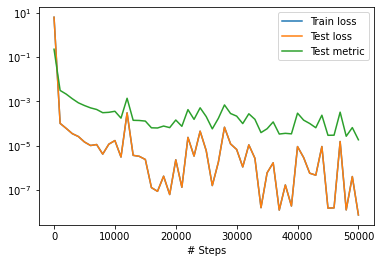

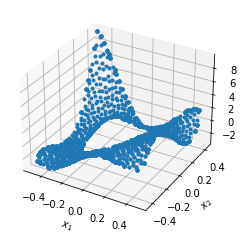

In [89]:
# Visualisation des résultats
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [90]:
# Prédiction et visualisation du mode
x = geom.random_points(10000)
y = model.predict(x)

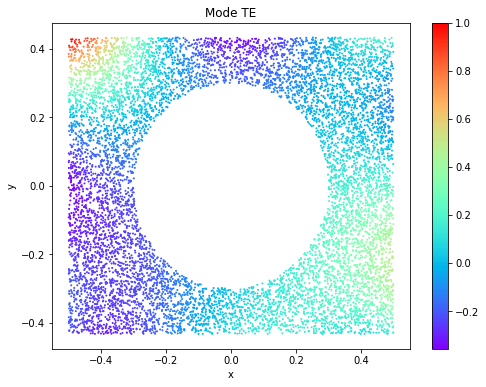

In [91]:
plt.figure(figsize=(8, 6))

#transform result into matrix, x[:, 0] is x, x[:, 1] is y and y is the result for each point 

plt.scatter(x[:, 0], x[:, 1], c=(y/np.max(y)), s=1, cmap="rainbow")
plt.colorbar()
plt.title("Mode TE")
plt.xlabel("x")
plt.ylabel("y")
plt.show()